## Contributors:

Stephan Zwicknagl (zwicknagl@uni-potsdam.de)

Ihtisham Ahmad (ahmad@uni-potsdam.de)

Group: SDAG

# Sheet 9 Exercise 2


In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [2]:
file = os.path.abspath("Rubix_cube_ps9.jpg")
path = os.path.dirname(file)

Load the jpg image and get its RGB representation (then each
pixel is given as an individual 3-dimensional data point ).
![rubix cube](Rubix_cube_ps9.jpg)

In [3]:
arr = np.array(Image.open(file))
print("This is a white pixel at [0,0]: " + str(arr[0,0]))
print("The pixel representation has shape: " + str(arr.shape))


This is a white pixel at [0,0]: [255 255 255]
The pixel representation has shape: (410, 400, 3)


This means that the resolution of the image is 410x400 where each pixel has 3 values (Red-,Green- and Blue-values).  

# Implement the k-means algorithm. 

We separate the K-means algorithm into two parts:
1. findMapping: This function finds the nearest cluster center of each data point (pixel) in the image and assigns it to the corresponding cluster. The assignment is represented with the R-matrix, a (n,nn,k)-matrix. Each pixel has a array of k values, where the value at position i is 1 iff i is the index of the nearest cluster. Else it is zero.

$R_{lmn} = \begin{cases} 1 & \text{iff } x_{lm}\in M_n \\ 0 & \text{else} \end{cases}$,

where $M_n$ is the $n$-th cluster and $x_{lm}$ the data point.

2. findMeans: This function calculates the new cluster centers. The new cluster centers are calculated by averaging the data points that belong to the cluster. The new cluster centers are represented by the k m-vectors, represented in a (k,m)-matrix. Each m-vector is the mean of all the data points that belong to the cluster. 

The two parts are managed in the function kmeans, which manages the (random) initialization of the cluster centers and the stopping criterion. We choose random initialization, because we want this algorithm to work with any picture. Since we don't want to assume any prior knowledge about the image, we can't assume maximal distances in the cluster centers.

In [4]:
def findMapping(X, Means):
    """
    Finds the closest cluster center for each pixel in X    
    Input:
        X: array of pixel values (shape: (n,nn,m), where n*nn is the image resolution and m is the number of color channels)
        Means: a array of cluster centers (shape: (k,m))
    Returns:
        Matrix R of size (n,nn,k) where R[l,m,n] is 
            1 iff pixel X[l,m] is assigned to cluster n
            0 otherwise
    """
    # initialize shapes
    n, nn, m = X.shape
    k = Means.shape[0]
    # initialize R in practical shape (will be reshaped later)
    R = np.zeros((n*nn, k))

    # bring X into shape (n*nn, m)
    X = arr.reshape((n*nn,m))

    # calculate the distance between each instance-mean pair 
    # using np.linalg.norm, use np.repeat and np.tile to bring X and Means into uesable order
    dist = np.linalg.norm(np.repeat(X, k, axis=0) -
                          np.tile(Means, (n * nn, 1)),
                          axis=1,
                          keepdims=True)

    # bring dist into shape (n*nn, k), so that each pixel 
    # has k values corresponding to the distance to each mean
    dist = dist.reshape(n*nn, k)

    # find the index of the closest mean
    # so that j is the vector of the indices of the closest cluster center of each pixel 
    j = np.argmin(dist, axis=1)

    # assign 1 to the closest mean, 0 otherwise
    R[np.arange(n*nn),j] = 1
    # reshape R into shape (n,nn,k)
    R = R.reshape((n,nn,k))

    return R


In [5]:
def findMeans(X, R):
    """
    function findMeans(X,R) that calculates new cluster centers
    for the data points in X and the cluster assignments R
    Input:
        X: array of pixel values (shape: (n,nn,m), where n*nn is the image resolution and m is the number of color channels)
        R: array of cluster assignments (shape: (n,nn,k), where n*nn is the image resolution and k is the number of clusters)
    Returns:
        Means: Array of Means
    """
    # initialize shapes
    n, nn, m = X.shape
    k = R.shape[-1]
    # initialize Means
    # they are reset and newly calculated in each iteration
    Means = np.zeros((k, m))

    # bring R into shape (n*nn, k)
    R = R.reshape((n*nn, k))
    # bring X into shape (n*nn, m)
    X = X.reshape((n*nn, m))

    # iterate over each cluster
    for i in range(k):
        # get the pixels that belong to cluster i and calculate their mean value
        Means[i] = X[np.where(R[:, i] == 1)].mean(axis=0)

    return Means

In [6]:
def kmeans(X, k, verbose=0, maxiter = 200, tolerance = 1e-2, random_state=3):
    """
    function kmeans(X,k) that performs k-means clustering
    Input:
        X: array of pixel values (m-dimensional)
        k: number of clusters
        verbose: mode of operation (0: silent, 1: print progress)
        maxiter: maximum number of iterations (stopping criterion)
        tolerance: relative tolerance for the number of difference in cluster assignemnts (stopping criterion)
        random_state: random seed
    Returns:
        y: array of cluster assignments (shape: n*nn)
        Means: centers of the clusters (shape: k,m)
    """
    # initialize shapes
    n, nn, m = X.shape
    y = np.zeros([n,nn,])
    # initialize R and stopping criterion for maxiter
    R = np.zeros((n,nn,k))
    i = 0
    
    # Initialize means randomly
    np.random.seed(random_state)
    Means = np.random.uniform(low=np.min(X), high=np.max(X), size=(k, m))

    # iterate until convergence or maxiter
    while True:
        # stopping criterion maxiter
        if i>maxiter:
            break
        i += 1

        if verbose == 1:
            print(Means)
        
        try:
            # calculate the cluster assignment for all pixels
            R_prime = findMapping(X, Means)
            # if R_prime is almost the same as R, then the algorithm has converged
            assert np.abs(R_prime - R).sum() < tolerance*R_prime.size
            break
        except AssertionError:
            # if they are different enough, then update the cluster assignment
            R = R_prime
            # and calculate the new cluster centers
            Means = findMeans(X, R)
    
    # calculate y, the cluster assignment for all pixels
    # y[lm] = j if pixel X[lm] is assigned to cluster j
    y = np.argmax(R.reshape((n*nn, k)), axis=1).reshape((n, nn))

    return (y, Means)


## Using k-means cluster all the pixels of an image into k clusters and assign each pixel the color represented by its nearest cluster center.

The function plotClusters takes the image and the number of cluster centers and runs the k-means algorithm.

In [7]:
def plot_clusters(X, k):
    # initialize recolored image
    recolor = np.zeros(X.shape)
    inertia = 0
    # run k-means
    y, Means = kmeans(X, k)

    # calculate inertia (SSE)
    # (Sum of squared distances of samples to their closest cluster center)
    for i in range(k):
        inertia += np.linalg.norm(X[np.where(y ==i)] - Means[i])**2

    # assign each pixel the color of the cluster center it belongs to
    for i in range(k):
        recolor[np.where(y == i)] = Means[i]

    # generate an image from the recolor array
    data = Image.fromarray(np.uint8(recolor))

    # create a new folder
    if not os.path.exists(os.path.join(path,'recolor')):
        os.mkdir(os.path.join(path, 'recolor'))

    # save as a PNG file
    data.save('recolor/rubix_{}-cluster.jpg'.format(k))

    return data, inertia

In [8]:
sse =[]

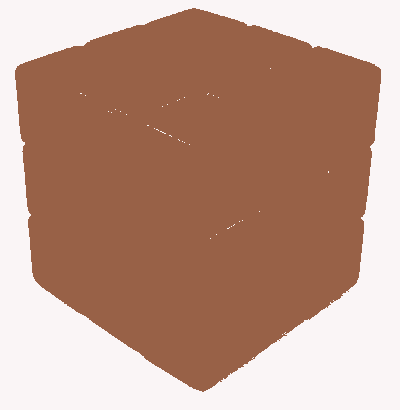

In [9]:
# 2 clusters
pic, inert = plot_clusters(arr, 2)
sse.append(inert)
pic

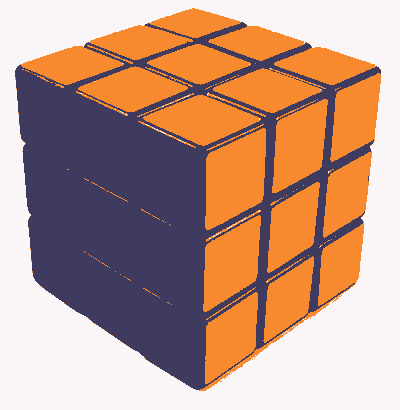

In [10]:
# 3 clusters
pic, inert = plot_clusters(arr, 3)
sse.append(inert)
pic

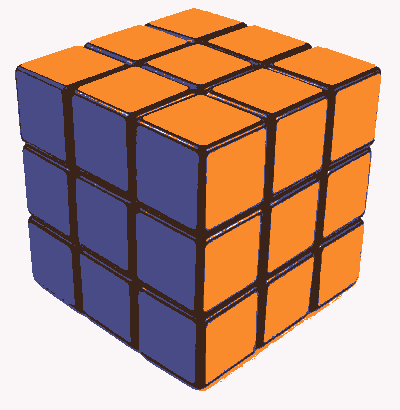

In [11]:
# 4 clusters
pic, inert = plot_clusters(arr, 4)
sse.append(inert)
pic

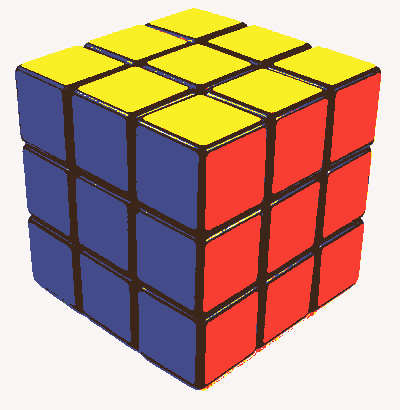

In [12]:
# 5 clusters
pic, inert = plot_clusters(arr, 5)
sse.append(inert)
pic

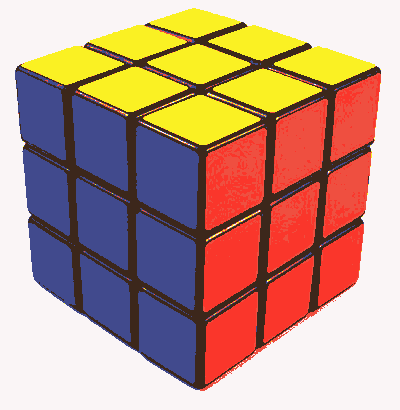

In [13]:
# 6 clusters
pic, inert = plot_clusters(arr, 6)
sse.append(inert)
pic

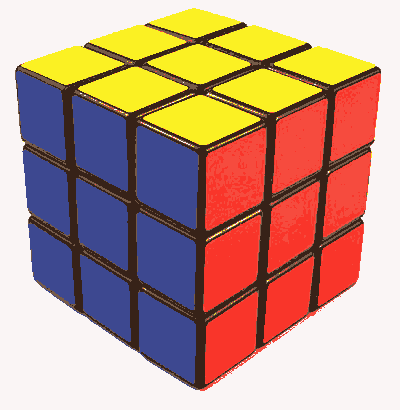

In [14]:
# 7 clusters
pic, inert = plot_clusters(arr, 7)
sse.append(inert)
pic

C:\Users\steph\AppData\Local\Temp/ipykernel_12092/1458198934.py:26: RuntimeWarning: Mean of empty slice.
  Means[i] = X[np.where(R[:, i] == 1)].mean(axis=0)
C:\Users\steph\anaconda3\envs\ml2\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


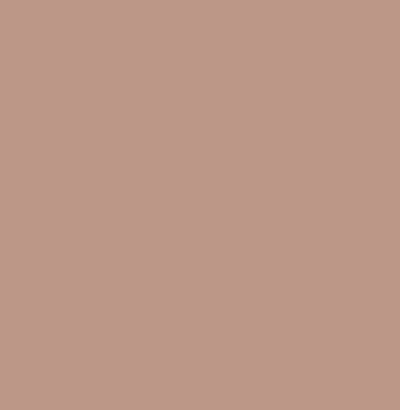

In [15]:
# 8 clusters
pic, inert = plot_clusters(arr, 8)
sse.append(inert)
pic

As we can see, the colors get mixed up. For $k=2,3,...,7$ clusters, a proper result is received. It shows the rubix cube, but its colors are not original. Blue and Orange as well as the black and white stay, although slightly shifted from their original color tone. The colors also seep out of the lines.  

Too many clusters lead to a bad result. The algorithm is not able to distinguish the colors. Only a certain area for the hyperparameter $k$ makes sense. 

Note that due to the random initialization, the result strongly depends on the initialization. We have chosen a seed for reproducability. With different seeds, the result is not always the same. Different initalization methods, like the k-means++ initialization, might be useful to obtain better and more stable results. This is not in the scope of this exercise.



Lastly, we want to find the optimal number of clusters for the Rubix cube as measured by the SSE. 

The SSE measures the distance of the data points to their cluster's center. A lower SSE means better clustering, because the variation within the cluster is smaller. We try to find an optimal number of clusters for the Rubix cube image. We pick the number of clusters at the knee of the SSE curve. There, the SSE is no longer decreasing rapidly with the number of clusters and it is no longer worth the further increases. It is the point of diminishing returns. 

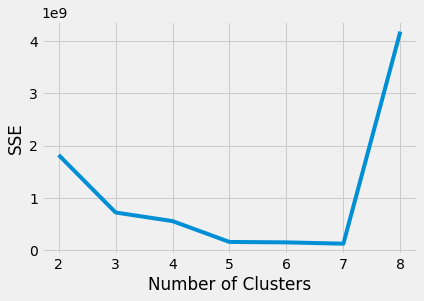

In [16]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 9), sse)
plt.xticks(range(2, 9))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The optimal number of clusters is where the knee of the graph is. It happens at k = 3.
The corresponding recolored image is:


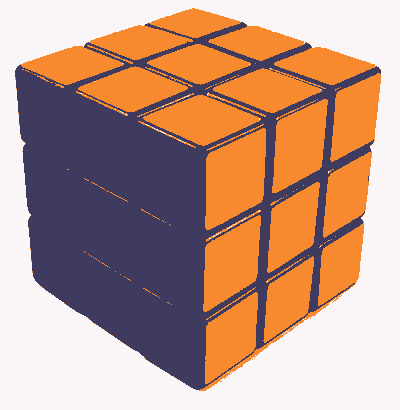

In [17]:
kl = KneeLocator(range(2, 9), sse, curve="convex", direction="decreasing")
print("The optimal number of clusters is where the knee of the graph is. It happens at k = {}.".format(kl.elbow))
print("The corresponding recolored image is:")
pic, inert = plot_clusters(arr, kl.elbow)
pic

References:

The kmeans implementation is adapted from an exercise from Intelligent Data Analysis and Machine Learning 2.